In [2]:
%pip install fairlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.1/234.1 kB 3.9 MB/s eta 0:00:00


In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import chi2_contingency

from fairlearn.metrics import demographic_parity_difference, demographic_parity_ratio, equalized_odds_difference, equalized_odds_ratio

In [35]:
def simulate_data(n, p_label_1, tpr, tnr, group_name=None):
  """
  Creates a dataframe of size n with true positive rate equal to tpr and true negative rate equal to tnr.

  Args:
    n: The size of the dataframe.
    p_label_1: The proportion of the group with the outcome 1.
    tpr: The true positive rate.
    tnr: The true negative rate.

  Returns:
    A dataframe of size n with true positive rate equal to tpr and true negative rate equal to tnr.
  """

  #create the array of women's actual outcomes
  labels = np.concatenate((np.ones(round(n*p_label_1)), np.zeros(n - round(n*p_label_1))))

  #model predictions when label = 1
  preds_label_1 = np.zeros(np.count_nonzero(labels))
  preds_label_1[:round(np.count_nonzero(labels)*tpr)] = 1

  #model predictions when label = 0
  preds_label_0 = np.ones(np.count_nonzero(labels==0))
  preds_label_0[:round(np.count_nonzero(labels==0)*tnr)] = 0

  preds = np.concatenate((preds_label_1, preds_label_0))

  if group_name:
    return pd.DataFrame({'label':labels, 'pred':preds, 'group':group_name})
  else:
    return pd.DataFrame({'label':labels, 'pred':preds})




In [36]:
def calculate_metrics(df):
  """
  Calculates the fairness metrics for a dataframe.

  Args:
    df: The dataframe.

  Returns:
    A dataframe with the fairness metrics.
    """

  #count true positive, etc within the sample

  women_tp= sum((df['group']=="women") & (df['label']==1) & (df['pred']==1))
  women_tn= sum((df['group']=="women") & (df['label']==0) & (df['pred']==0))
  women_fp= sum((df['group']=="women") & (df['label']==0) & (df['pred']==1))
  women_fn= sum((df['group']=="women") & (df['label']==1) & (df['pred']==0))
  women_sel_rate = sum((df['group']=="women") & (df['pred']==1))/sum((df['group']=="women"))


  men_tp= sum((df['group']=="men") & (df['label']==1) & (df['pred']==1))
  men_tn= sum((df['group']=="men") & (df['label']==0) & (df['pred']==0))
  men_fp= sum((df['group']=="men") & (df['label']==0) & (df['pred']==1))
  men_fn= sum((df['group']=="men") & (df['label']==1) & (df['pred']==0))
  men_sel_rate = sum((df['group']=="men") & (df['pred']==1))/sum((df['group']=="men"))

  #note women_sel_rate / men_sel_rate is equal to demographic parity ratio

  return {"women_tp":women_tp, "women_tn":women_tn, "women_fp":women_fp, "women_fn":women_fn, "women_correct_pred":women_tp+women_tn, "women_incorrect_pred":women_fp+women_fn,
          "women_correct_pred_rate":(women_tp+women_tn)/(women_fp+women_fn+women_tp+women_tn), "women_ppv":women_tp/(women_tp+women_fp),"women_sel_rate":women_sel_rate,
          "men_tp":men_tp, "men_tn":men_tn, "men_fp":men_fp, "men_fn":men_fn, "men_correct_pred":men_tp+men_tn, "men_incorrect_pred":men_fp+men_fn,
          "men_correct_pred_rate":(men_tp+men_tn)/(men_fp+men_fn+men_tp+men_tn), "men_ppv":men_tp/(men_tp+men_fp), "men_sel_rate":men_sel_rate}


In [37]:
def barplot_metrics(metrics, alpha=1):
  #metrics = calculate_metrics(sample)
  # Data for the chart
  categories = ['True Positives', 'False Positives', 'True Negatives', 'False Negatives']
  men = [metrics["men_tp"], metrics["men_fp"], metrics["men_tn"], metrics["men_fn"]]  # Example statistics for men
  women = [metrics["women_tp"], metrics["women_fp"], metrics["women_tn"], metrics["women_fn"]]   # Example statistics for women

  # Position of bars on the x-axis
  x = np.arange(len(categories))

  # Bar width
  bar_width = 0.35

  # Create the bar chart
  fig, ax = plt.subplots()
  bars1 = ax.bar(x - bar_width/2, men, bar_width, label='Men', alpha=alpha)
  bars2 = ax.bar(x + bar_width/2, women, bar_width, label='Women', alpha=alpha)

  # Add labels, title, and legend
  ax.set_xlabel('Categories')
  ax.set_ylabel('Counts')
  ax.set_title('Outcomes by Gender')
  ax.set_xticks(x)
  ax.set_xticklabels(categories)
  ax.legend()

  # Display the chart
  plt.show()


In [38]:
def pie_chart_metrics(metrics, alpha=1):

  labels = ['Correct', 'Incorrect']
  men = [metrics["men_correct_pred"], metrics["men_incorrect_pred"]]  # Example data for the first pie chart
  women = [metrics["women_correct_pred"], metrics["women_incorrect_pred"]]  # Example data for the second pie chart

  # Create a figure with two subplots (side by side)
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


  # Create the first pie chart
  ax1.pie(men, labels=labels, autopct='%1.1f%%', startangle=90, wedgeprops={"alpha": alpha})
  ax1.set_title('Men')

  # Create the second pie chart
  ax2.pie(women, labels=labels, autopct='%1.1f%%', startangle=90, wedgeprops={"alpha": alpha})
  ax2.set_title('Women')

  # Adjust the layout to make room for titles and labels
  plt.tight_layout()

  # Display the charts
  plt.show()

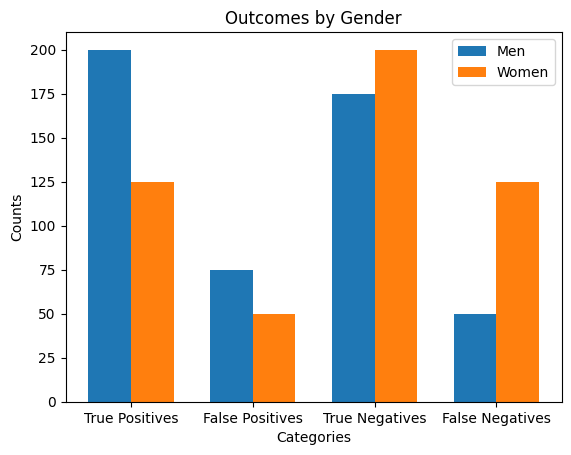

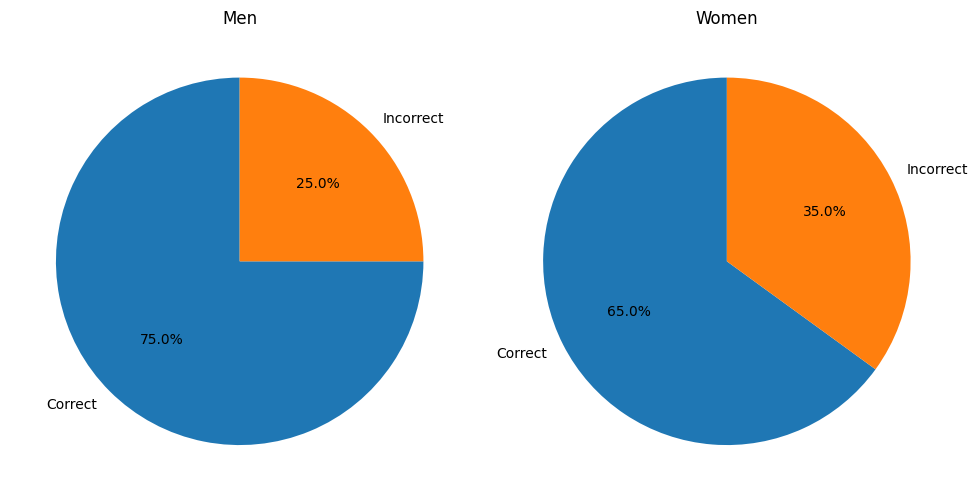

Demographic parity ratio:0.6363636363636362
Accuracy ratio:0.8666666666666667
PPV ratio:0.9821428571428571


In [39]:
#create dataframe containing the entire sampling frame, AKA population
women_population = simulate_data(n=500, p_label_1=0.5, tpr=0.5, tnr=0.8, group_name='women')
men_population = simulate_data(n=500, p_label_1=0.5, tpr=0.8, tnr=0.7, group_name='men')
population = pd.concat([women_population, men_population], axis=0)
population['correct_pred'] = population['pred'] == population['label']

pop_metrics=calculate_metrics(population)
barplot_metrics(pop_metrics)
pie_chart_metrics(pop_metrics)

pop_metrics["demographic_parity_difference"] = demographic_parity_difference(population['label'], population['pred'], sensitive_features=population['group'])
pop_metrics["demographic_parity_ratio"] = demographic_parity_ratio(population['label'], population['pred'], sensitive_features=population['group'])
pop_metrics["equalized_odds_difference"] = equalized_odds_difference(population['label'], population['pred'], sensitive_features=population['group'])
pop_metrics["equalized_odds_ratio"] = equalized_odds_ratio(population['label'], population['pred'], sensitive_features=population['group'])
# pop_metrics["women_correct_pred_rate"] = pop_metrics["women_correct_pred"] / (pop_metrics["women_correct_pred"] + pop_metrics["women_incorrect_pred"])
# pop_metrics["men_correct_pred_rate"] = pop_metrics["men_correct_pred"] / (pop_metrics["men_correct_pred"] + pop_metrics["men_incorrect_pred"])

print(f"Demographic parity ratio:{pop_metrics['demographic_parity_ratio']}")
print(f"Accuracy ratio:{pop_metrics['women_correct_pred']/pop_metrics['men_correct_pred']}")
print(f"PPV ratio:{pop_metrics['women_ppv']/pop_metrics['men_ppv']}")



In [60]:
def simulate_audit (women_population, men_population, sample_size=50):
  sample_metrics = []
  sample_stats = []

  for sample_num in range(50):
    #randomly sample men and women from their respective sampling frames, then concatenate them
    women_sample = women_population.sample(n=sample_size, random_state=sample_num)
    men_sample = men_population.sample(n=sample_size, random_state=sample_num)
    sample = pd.concat([women_sample, men_sample], axis=0)
    sample['correct_pred'] = sample['pred'] == sample['label']

    #calculate metrics
    metrics = calculate_metrics(sample)
    metrics["sample_num"] = sample_num
    metrics["demographic_parity_difference"] = demographic_parity_difference(sample['label'], sample['pred'], sensitive_features=sample['group'])
    metrics["demographic_parity_ratio"] = demographic_parity_ratio(sample['label'], sample['pred'], sensitive_features=sample['group'])
    metrics["equalized_odds_difference"] = equalized_odds_difference(sample['label'], sample['pred'], sensitive_features=sample['group'])
    metrics["equalized_odds_ratio"] = equalized_odds_ratio(sample['label'], sample['pred'], sensitive_features=sample['group'])

    #perform a hypothesis test on overall accuracy for men vs. women
    chisq_data = sample[['group', 'correct_pred']]
    contingency_table = pd.crosstab(sample['group'], sample['correct_pred'])
    stat, pvalue, dof, expected = chi2_contingency(contingency_table, correction = False)
    accuracy = {'chisq':stat, 'p':pvalue, 'dof':dof, 'exp':expected}

    #perform a hypothesis test for true positive rate for men vs. women (i.e., of qualified applicants, how often did the model correctly predict them as qualified?)
    qualified_candidates = sample.loc[(sample['label'] == 1)]
    contingency_table = pd.crosstab(qualified_candidates['group'], qualified_candidates['correct_pred'])
    stat, pvalue, dof, expected = chi2_contingency(contingency_table, correction = False)
    tpr = {'chisq':stat, 'p':pvalue, 'dof':dof, 'exp':expected}

    #Perform a hypothesis test for selection rate for men vs. women (i.e., for all men and women, how often did the model predict them as qualified?)
    contingency_table = pd.crosstab(sample['group'], sample['pred'])
    contingency_table
    stat, pvalue, dof, expected = chi2_contingency(contingency_table, correction = False)
    sel_rate = {'chisq':stat, 'p':pvalue, 'dof':dof, 'exp':expected}

    stats = {"sample_num":sample_num,"accuracy":accuracy, "tpr":tpr, "selection_rate":sel_rate}

    sample_metrics.append(metrics)
    sample_stats.append(stats)

  return sample_metrics, sample_stats

In [61]:
sample_metrics, sample_stats = simulate_audit(women_population, men_population, sample_size=50)
pd.DataFrame(sample_metrics).sort_values(by='demographic_parity_ratio', ascending=False).head(20)

,women_tp,women_tn,women_fp,women_fn,women_correct_pred,women_incorrect_pred,women_correct_pred_rate,women_ppv,women_sel_rate,men_tp,...,men_correct_pred,men_incorrect_pred,men_correct_pred_rate,men_ppv,men_sel_rate,sample_num,demographic_parity_difference,demographic_parity_ratio,equalized_odds_difference,equalized_odds_ratio
22,15,20,9,6,35,15,0.70,0.625000,0.48,18,...,37,13,0.74,0.642857,0.56,22,0.08,0.857143,0.142857,0.833333
42,18,18,8,6,36,14,0.72,0.692308,0.52,22,...,39,11,0.78,0.709677,0.62,42,0.10,0.838710,0.166667,0.818182
47,13,20,7,10,33,17,0.66,0.650000,0.40,19,...,39,11,0.78,0.730769,0.52,47,0.12,0.769231,0.260870,0.684211
24,18,20,2,10,38,12,0.76,0.900000,0.40,23,...,42,8,0.84,0.884615,0.52,24,0.12,0.769231,0.178571,0.666667
20,16,16,7,11,32,18,0.64,0.695652,0.46,22,...,37,13,0.74,0.733333,0.60,20,0.14,0.766667,0.222222,0.727273
45,11,21,5,13,32,18,0.64,0.687500,0.32,15,...,35,15,0.70,0.714286,0.42,45,0.10,0.761905,0.166667,0.733333
30,16,13,7,14,29,21,0.58,0.695652,0.46,23,...,35,15,0.70,0.741935,0.62,30,0.16,0.741935,0.233333,0.695652
43,12,21,7,10,33,17,0.66,0.631579,0.38,19,...,40,10,0.80,0.730769,0.52,43,0.14,0.730769,0.318182,0.631579
12,11,26,5,8,37,13,0.74,0.687500,0.32,15,...,39,11,0.78,0.681818,0.44,12,0.12,0.727273,0.210526,0.714286
14,15,21,5,9,36,14,0.72,0.750000,0.40,22,...,42,8,0.84,0.785714,0.56,14,0.16,0.714286,0.291667,0.681818


In [58]:
sample_stats[2]

{'sample_num': 2,
 'accuracy': {'chisq': 1.5280135823429541,
  'p': 0.21641081558523914,
  'dof': 1,
  'exp': array([[19., 31.],
         [19., 31.]])},
 'tpr': {'chisq': 8.116883116883118,
  'p': 0.004385489392093787,
  'dof': 1,
  'exp': array([[11., 14.],
         [11., 14.]])},
 'selection_rate': {'chisq': 7.954545454545453,
  'p': 0.004796675418874549,
  'dof': 1,
  'exp': array([[28., 22.],
         [28., 22.]])}}

0.6307728398360838
0.10023278049829515


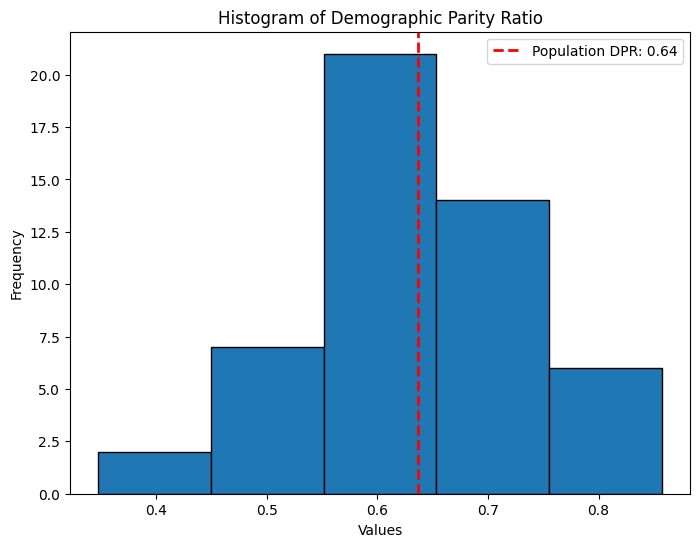

In [48]:
print(sample_metrics_df['demographic_parity_ratio'].mean())
print(sample_metrics_df['demographic_parity_ratio'].std())

#calculate the demographic parity ratio for the population
pop_dpr = pop_metrics['demographic_parity_ratio']

# Creating the histogram for 'Column1'
plt.figure(figsize=(8, 6))
plt.hist(sample_metrics_df['demographic_parity_ratio'], bins=5, edgecolor='black')
# Add a vertical line at the population mean
plt.axvline(pop_dpr, color='red', linestyle='dashed', linewidth=2, label=f'Population DPR: {pop_dpr:.2f}')


# Adding labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Demographic Parity Ratio')
plt.legend()

# Display the histogram
plt.show()

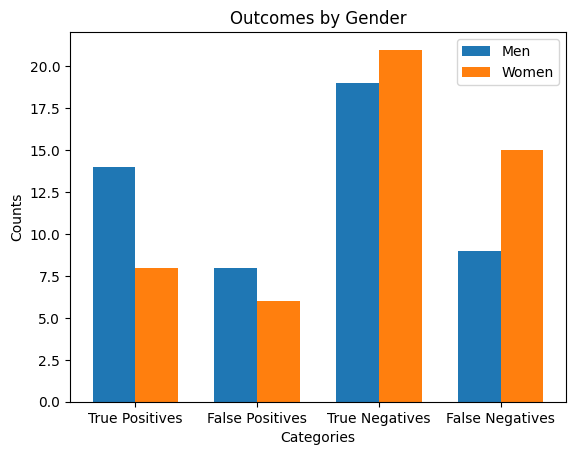

In [49]:
metrics = calculate_metrics(sample)
barplot_metrics(metrics)

In [50]:
#perform a hypothesis test for all people, considering correct and incorrect predictinos
chisq_data = sample[['group', 'correct_pred']]
contingency_table = pd.crosstab(sample['group'], sample['correct_pred'])
contingency_table
stat, pvalue, dof, expected = chi2_contingency(contingency_table, correction = False)
print(f"Chi square test on accuracy: {stat, pvalue, dof, expected}")

#compute statistics for the subset of candidates that are actually qualified
qualified_candidates = sample.loc[(sample['label'] == 1)]
contingency_table = pd.crosstab(qualified_candidates['group'], qualified_candidates['correct_pred'])
contingency_table
stat, pvalue, dof, expected = chi2_contingency(contingency_table, correction = False)
print(f"Chi square test on true positive rate: {stat, pvalue, dof, expected}")

#compute statistics based on selection rate
contingency_table = pd.crosstab(sample['group'], sample['pred'])
contingency_table
stat, pvalue, dof, expected = chi2_contingency(contingency_table, correction = False)
print(f"Chi square test on selection rate: {stat, pvalue, dof, expected}")





Chi square test on accuracy: (0.6791171477079796, 0.40989089696161085, 1, array([[19., 31.],
       [19., 31.]]))
Chi square test on true positive rate: (3.1363636363636367, 0.07656433392497305, 1, array([[12., 11.],
       [12., 11.]]))
Chi square test on selection rate: (2.7777777777777777, 0.09558070454562936, 1, array([[32., 18.],
       [32., 18.]]))


In [45]:
contingency_table

pred,0.0,1.0
group,,
men,17,8
women,19,6


In [ ]:
# prompt: A python function for conducting a power analysis from simulated data.  The simulation should be for correctly rejecting the null hypothesis for a comparison of two groups with a binary outcome. Include a second function that plots the results across simulations.

def power_analysis_binary(p1, p2, n_per_group, alpha=0.05, n_simulations=1000):
  """
  Conducts a power analysis for a binary outcome.

  Args:
    p1: Probability of success in group 1.
    p2: Probability of success in group 2.
    n_per_group: Sample size per group.
    alpha: Significance level.
    n_simulations: Number of simulations.

  Returns:
    Estimated power.
  """
  significant_results = 0
  for _ in range(n_simulations):
    group1 = np.random.binomial(1, p1, n_per_group)
    group2 = np.random.binomial(1, p2, n_per_group)
    #_, p_value = stats.ttest_ind(group1, group2)

    # Creating a contingency table
    contingency_table = pd.crosstab(data[col1], data[col2])

    # Performing the Chi-Square Test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Interpreting the result
    significant = p < 0.05  # 5% significance level
    return chi2, p, significant

    if p_value < alpha:
      significant_results += 1
  return significant_results / n_simulations

#Function below is not really what I want. Revise
# def plot_power_analysis(p1_range, p2, n_per_group, alpha=0.05, n_simulations=1000):
#   """
#   Plots power analysis results.

#   Args:
#     p1_range: Range of probabilities for group 1.
#     p2: Probability of success in group 2.
#     n_per_group: Sample size per group.
#     alpha: Significance level.
#     n_simulations: Number of simulations.
#   """
#   powers = [power_analysis_binary(p1, p2, n_per_group, alpha, n_simulations)
#             for p1 in p1_range]
#   plt.plot(p1_range, powers)
#   plt.xlabel("Probability of Success in Group 1 (p1)")
#   plt.ylabel("Power")
#   plt.title("Power Analysis for Binary Outcome")
#   plt.grid(True)
#   plt.show()


In [ ]:
#https://www.jonathanbossio.com/post/two-sample-chi-square-test-with-python
#https://stats.oarc.ucla.edu/other/gpower/two-independent-proportions-power-analysis/